In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
import napari

In [2]:
import owncloud
import os

if not os.path.exists('data'):
    print('Creating directory for data')
    os.mkdir('data')

if not os.path.exists('data/data.tif'):
    oc = owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/bFDLSfaxRqKlqT7')
    oc.get_file('/', 'data/data.tif');

In [3]:
movie = tifffile.imread('data/data.tif')
movie.shape

(3000, 170, 170)

## Recognizing Motion

Before beginning motion correction, it is important to first recognize the type and extent of motion present in the calcium imaging dataset. This section introduces the process of visually and quantitatively identifying motion artifacts and determining whether rigid correction is appropriate. You will also prepare the dataset by generating a reference frame and ensuring consistent intensity across frames. These preparatory steps are essential for enabling accurate and reliable correction in the following stages.

*How do I see if there is motion?*

**Example** Open and play movie in napari. Is there motion?

In [33]:
viewer = napari.Viewer()

In [5]:
viewer.add_image(movie)

<Image layer 'movie' at 0x2165c526ab0>

Open the first 200 frames of the movie. Is there motion?

In [6]:
viewer.add_image(movie[:200])

<Image layer 'Image' at 0x2165dcbade0>

Open the frames between 1000 and 1200 of the movie. Is there motion?

In [7]:
viewer.add_image(movie[1000:1200])

<Image layer 'Image [1]' at 0x2165da14ef0>

Will this motion make summary images blurry?

**Example** Create mean projection of all the frames of the movie.

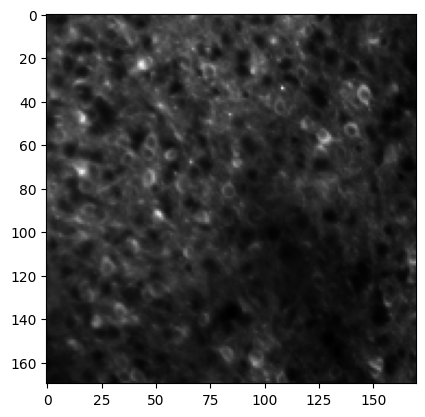

In [8]:
proj = movie.mean(axis=0)
plt.imshow(proj, cmap='gray')

Create mean projection of frames between 1000 and 1200 of the movie.

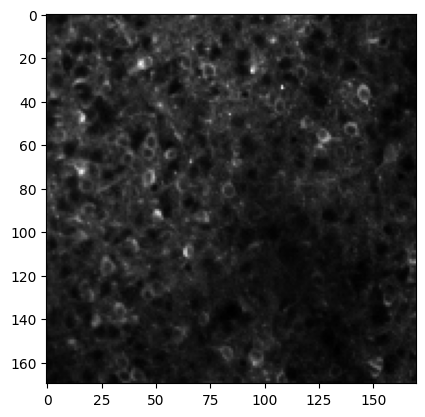

In [9]:
proj = movie[1000:1200].mean(axis=0)
plt.imshow(proj, cmap='gray')

Create mean projection of frames of the first 200 frames of the movie.

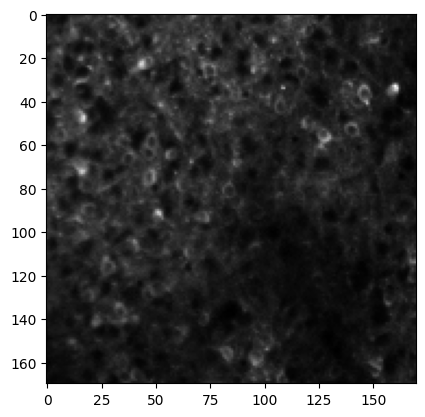

In [10]:
proj = movie[:200].mean(axis=0)
plt.imshow(proj, cmap='gray')

## **Estimating Frame Shifts Relative to a Reference**

To correct for motion, it is necessary to know how much each frame in the movie has shifted relative to a stable reference. This section introduces the concept of shift estimation by comparing each frame to the reference image. The outcome is a set of displacement values for each frame that can be used to realign the dataset. By the end of this section, you will understand how motion is quantified and how to structure this information for use in the correction step.

Each shift is a pair of values: [dy, dx], indicating how much the image needs to move to align with the reference frame.

|                       | `dy` (Vertical Shift)     | `dx` (Horizontal Shift)   |
|-----------------------|---------------------------|---------------------------|
| **Meaning**           | Vertical movement         | Horizontal movement       |
| **Positive Value**    | Move frame **downward**   | Move frame **right**      |
| **Negative Value**    | Move frame **upward**     | Move frame **left**       |

*How do I get shifts of of frames with respect to a frame in the movie?*

**Example** Compute shifts between the first frame and the zeroth frame.

In [11]:
shift_val, _, _ = phase_cross_correlation(movie[0], movie[1])
shift_val

array([0., 0.], dtype=float32)

Compute shifts between frame 0 and the last frame.

In [12]:
shift_val, _, _ = phase_cross_correlation(movie[0], movie[-1])
shift_val

array([1., 0.], dtype=float32)

Compute shifts between the 1000th frame and the 200th frame.

In [13]:
shift_val, _, _ = phase_cross_correlation(movie[1000], movie[200])
shift_val

array([1., 1.], dtype=float32)

*How do I compute shifts between a frame and a summary frame?*

**Example** What is the shift between the first frame and mean projection of all frames?

In [14]:
sum_frame = movie.mean(axis=0)
shift_val, _, _ = phase_cross_correlation(sum_frame, movie[0])
shift_val

array([0., 0.], dtype=float32)

What is the shift between the first frame and mean projection of frames between 1000 and 1200?

In [15]:
sum_frame = movie[1000:1200].mean(axis=0)
shift_val, _, _ = phase_cross_correlation(sum_frame, movie[0])
shift_val

array([ 0., -1.], dtype=float32)

What is the shift between the last frame and mean projection of frames between 1000 and 1200?

In [16]:
sum_frame = movie[1000:1200].mean(axis=0)
shift_val, _, _ = phase_cross_correlation(sum_frame, movie[-1])
shift_val

array([1., 0.], dtype=float32)

*How do I align a frame with another frame?*

**Example** Align second frame with the first frame.

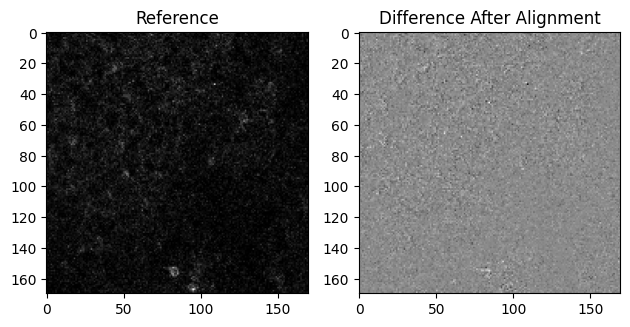

In [17]:
shift_val, _, _ = phase_cross_correlation(movie[0], movie[1])  
aligned = shift(movie[1], shift=shift_val)  

plt.subplot(1, 2, 1)
plt.imshow(movie[0], cmap='gray')  
plt.title("Reference")

plt.subplot(1, 2, 2)
plt.imshow(aligned - movie[0], cmap='gray')  
plt.title("Difference After Alignment")

plt.tight_layout()


Align 201th frame with the first frame.

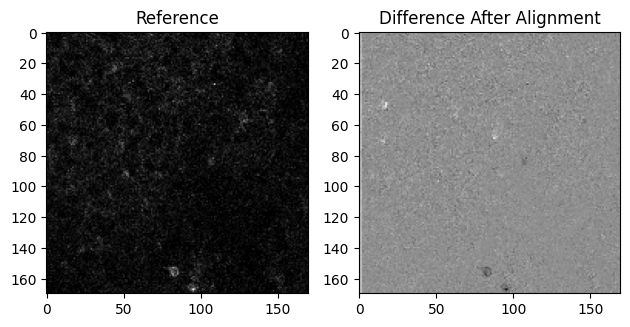

In [18]:
shift_val, _, _ = phase_cross_correlation(movie[0], movie[200])  
aligned = shift(movie[200], shift=shift_val)  

plt.subplot(1, 2, 1)
plt.imshow(movie[0], cmap='gray')  
plt.title("Reference")

plt.subplot(1, 2, 2)
plt.imshow(aligned - movie[0], cmap='gray')  
plt.title("Difference After Alignment")

plt.tight_layout()


Align the last frame with the first frame.

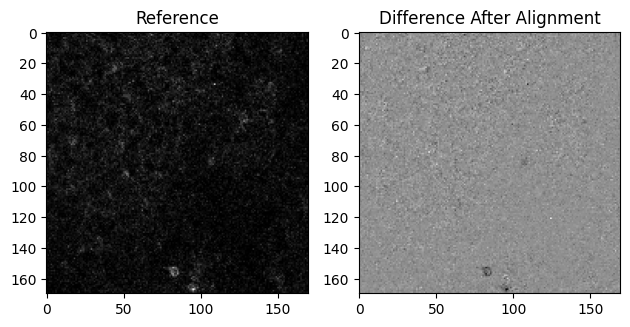

In [19]:
shift_val, _, _ = phase_cross_correlation(movie[0], movie[-1])  
aligned = shift(movie[-1], shift=shift_val)  

plt.subplot(1, 2, 1)
plt.imshow(movie[0], cmap='gray')  
plt.title("Reference")

plt.subplot(1, 2, 2)
plt.imshow(aligned - movie[0], cmap='gray')  
plt.title("Difference After Alignment")

plt.tight_layout()


*How do I align my frame with a summary frame?*

**Example** Align the first frame with mean projection of all frames.

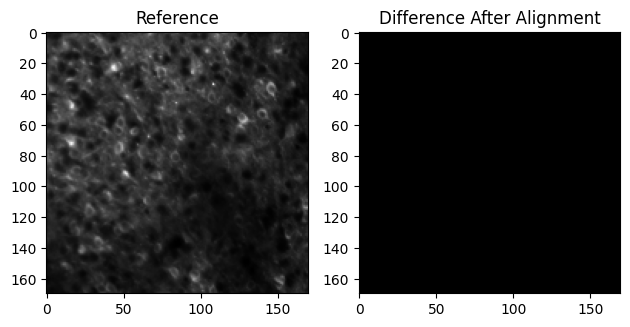

In [20]:
sum_frame = movie.mean(axis=0)
shift_val, _, _ = phase_cross_correlation(sum_frame, movie[0])  
aligned = shift(movie[0], shift=shift_val)  

plt.subplot(1, 2, 1)
plt.imshow(sum_frame, cmap='gray')  
plt.title("Reference")

plt.subplot(1, 2, 2)
plt.imshow(aligned - movie[0], cmap='gray')  
plt.title("Difference After Alignment")

plt.tight_layout()


Align the first frame with mean projection of frames between 1000 and 1200.

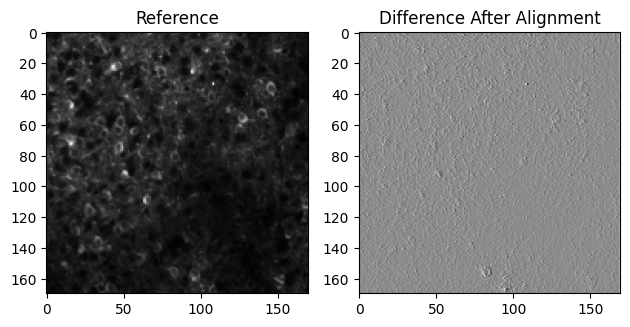

In [21]:
sum_frame = movie[1000:1200].mean(axis=0)
shift_val, _, _ = phase_cross_correlation(sum_frame, movie[0])  
aligned = shift(movie[0], shift=shift_val)  

plt.subplot(1, 2, 1)
plt.imshow(sum_frame, cmap='gray')  
plt.title("Reference")

plt.subplot(1, 2, 2)
plt.imshow(aligned - movie[0], cmap='gray')  
plt.title("Difference After Alignment")

plt.tight_layout()


Align the last frame with mean projection of all frame between 1000 and 1200.

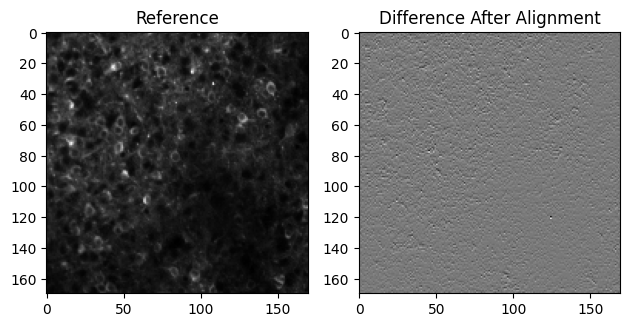

In [22]:
sum_frame = movie[1000:1200].mean(axis=0)
shift_val, _, _ = phase_cross_correlation(sum_frame, movie[-1])  
aligned = shift(movie[-1], shift=shift_val)  

plt.subplot(1, 2, 1)
plt.imshow(sum_frame, cmap='gray')  
plt.title("Reference")

plt.subplot(1, 2, 2)
plt.imshow(aligned - movie[-1], cmap='gray')  
plt.title("Difference After Alignment")

plt.tight_layout()


**Demo** Estimate shifts for all frames

In [23]:
sum_frame = movie[1000:1200].mean(axis=0)


shifts = np.array([phase_cross_correlation(sum_frame, frame)[0] for frame in movie])

## Motion Trace

The motion trace is a plot of frame-by-frame shifts along the X and Y directions. 

**A good trace should look have**
- small fluctuations.
- no sudden jumps between neighboring frames.

**Signs of outliers**
- sudden spike in shift (Y or X direction).
- flatline followed by a jump could suggest a movement event or an error in frame reading.
- one frame with extreme values compared to neighbors which may need to be excluded or handled separately.

*How do I see if my frames were affected significantly by motion*

**Example** Plot motion trace by estimating shifts with respect to the first frame.

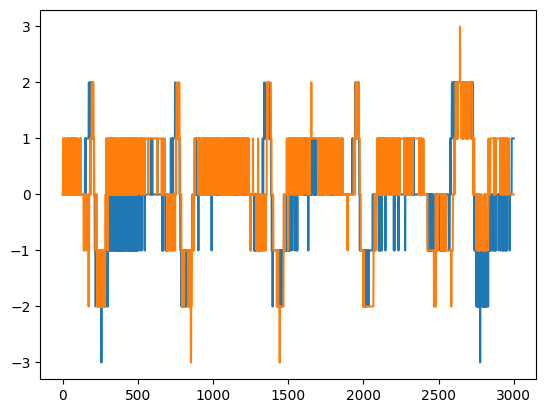

In [24]:
sum_frame = movie[0]
shifts = np.array([phase_cross_correlation(sum_frame, frame)[0] for frame in movie])
plt.plot(shifts);

Plot motion trace by estimating shifts with respect to the mean projection of all frames.

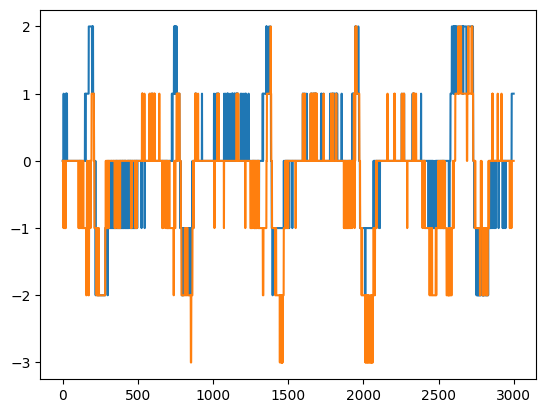

In [25]:
sum_frame = movie.mean(axis=0)
shifts = np.array([phase_cross_correlation(sum_frame, frame)[0] for frame in movie])
plt.plot(shifts);

Plot motion trace by estimating shifts with respect to the mean projection of frames between 1000 and 1200.

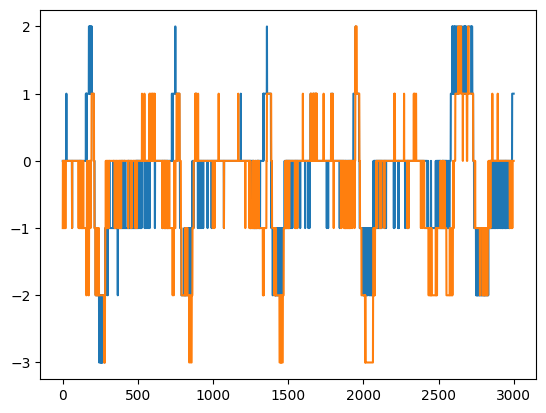

In [26]:
sum_frame = movie[1000:1200].mean(axis=0)
shifts = np.array([phase_cross_correlation(sum_frame, frame)[0] for frame in movie])
plt.plot(shifts);

*How do I handle borders?*

| Mode        | What It Does                                                                 | Expected Plot Behavior                          |
|-------------|------------------------------------------------------------------------------|-------------------------------------------------|
| `constant`  | Pads shifted-in regions with a fixed value (default = 0)                     | Sudden **spikes or drops** in intensity at frames with large shifts |
| `nearest`   | Extends the edge of the image by repeating the closest pixel                 | **Smooth**, closely tracks the original trace   |
| `reflect`   | Mirrors pixel values from inside the image at the edges                      | **Smooth**, but with slightly more variation    |

**Example** Apply constant border and compare intensity variation for top 5 pixels of original and motion corrected mean projections

In [27]:
sum_frame = movie[1000:1200].mean(axis=0)
shifts = np.array([phase_cross_correlation(sum_frame, frame)[0] for frame in movie])

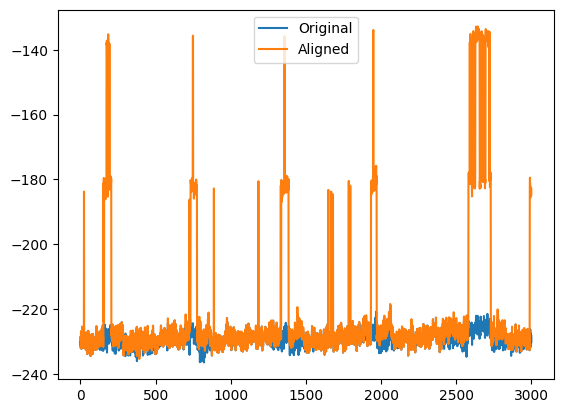

In [28]:
aligned = np.array([shift(f, shift=sh, mode='constant') for f, sh in zip(movie, shifts)])

border_orig = np.mean(movie[:, :5, :], axis=(1,2))
border_aligned = np.mean(aligned[:, :5, :], axis=(1,2))

plt.plot(border_orig, label='Original')
plt.plot(border_aligned, label='Aligned')
plt.legend()

Apply nearest border and compare intensity variation for top 5 pixels of original and motion corrected mean projections

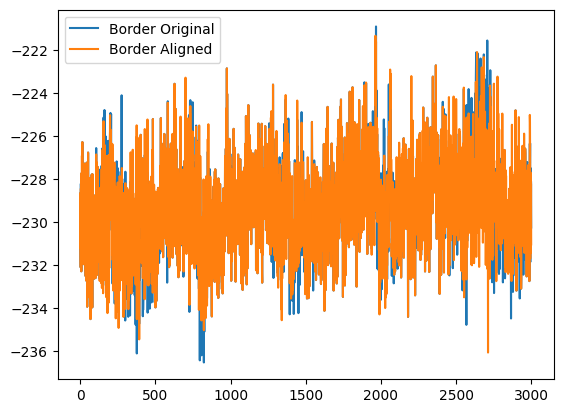

In [29]:
aligned = np.array([shift(f, shift=sh, mode='nearest') for f, sh in zip(movie, shifts)])

top_orig = np.mean(movie[:, :5, :], axis=(1, 2))
top_corr = np.mean(aligned[:, :5, :], axis=(1, 2))

plt.plot(top_orig, label='Border Original')
plt.plot(top_corr, label='Border Aligned')
plt.legend()

Apply reflect border and compare intensity variation for top 5 pixels of original and motion corrected mean projections

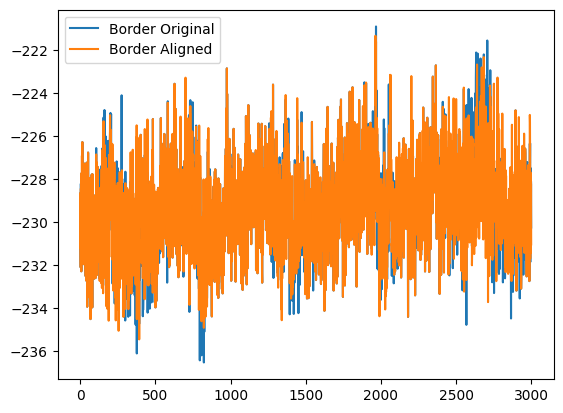

In [30]:
aligned = np.array([shift(f, shift=sh, mode='reflect') for f, sh in zip(movie, shifts)])

top_orig = np.mean(movie[:, :5, :], axis=(1, 2))
top_corr = np.mean(aligned[:, :5, :], axis=(1, 2))

plt.plot(top_orig, label='Border Original')
plt.plot(top_corr, label='Border Aligned')
plt.legend()

**DEMO** Seeing motion corrected video

In [ ]:
viewer.add_image(aligned)

<Image layer 'aligned' at 0x21661bbb0e0>

In [34]:
viewer.add_image(aligned - movie)

<Image layer 'Image' at 0x21661f9ad50>